# 라이브러리 불러오기

In [3]:
# ! pip install -U imbalanced-learn scikit-learn

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import matplotlib.pyplot as plt

from nltk.tokenize import TreebankWordTokenizer # 표준 토큰화
from nltk.corpus import stopwords # 불용어 제거
from nltk.stem import WordNetLemmatizer # 기본 형태로 변환
from imblearn.under_sampling import NeighbourhoodCleaningRule # 비대칭이라 사용

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
display(train_df.head())
display(test_df.head())

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [5]:
train_df.groupby('first_party_winner').size()

first_party_winner
0     829
1    1649
dtype: int64

# 데이터 전처리

In [6]:
# 문자 처리
cat_cols = ['first_party', 'second_party', 'facts']

# \b : 단어 경계, W* : 길이가 0이상이고 단어가 아닌 문자, w{1} : 길이가 1인 단어
short_word = re.compile(r'\W*\b\w{1}\b') # 길이가 1인 단어 찾기
tokenizer = TreebankWordTokenizer() # 단어 단위로 토큰화
stopword = stopwords.words('english') # 불용어 리스트 가져오기
lemmatizer = WordNetLemmatizer() # 단어의 기본 형태 가져오기

In [7]:
vec = CountVectorizer(ngram_range = (1, 2)) # 출현빈도
vec_facts = TfidfVectorizer(ngram_range = (1, 2)) # 단어토큰

## 단어 처리

In [8]:
def prepro1(df, cols, short_word, tokenizer, stopword, lemmatizer):
    first_party_lst = []
    second_party_lst = []
    facts_lst = []
    
    for col in cols:
        df[col] = df[col].str.strip() # 공백 제거
        df[col] = df[col].str.lower() # 소문자로 변경
        df[col] = df[col].str.replace(',', '')
        df[col] = df[col].str.replace('.', '')
        
        if col == 'first_party':
            for content in df[col]:
                content = short_word.sub('', content) # 한 글자 단어 제거
                com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
                content = com.sub('', content)
                tokens = tokenizer.tokenize(content) # 단어 토큰화
                token_lst = []
                for token in tokens:
                    if token not in stopword: #불용어 제거
                        token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
                first_party_lst.append(token_lst)
            # 단어들 결합
            for i in range(len(first_party_lst)):
                first_party_lst[i] = ' '.join(first_party_lst[i])
                
        elif col == 'second_party':
            for content in df[col]:
                content = short_word.sub('', content) # 한 글자 단어 제거
                com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
                content = com.sub('', content)
                tokens = tokenizer.tokenize(content) # 단어 토큰화
                token_lst = []
                for token in tokens:
                    if token not in stopword: #불용어 제거
                        token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
                second_party_lst.append(token_lst)
            # 단어들 결합
            for i in range(len(second_party_lst)):
                second_party_lst[i] = ' '.join(second_party_lst[i])
                
        elif col == 'facts':
            for content in df[col]:
                content = short_word.sub('', content) # 한 글자 단어 제거
                com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
                content = com.sub('', content)
                tokens = tokenizer.tokenize(content) # 단어 토큰화
                token_lst = []
                for token in tokens:
                    if token not in stopword: #불용어 제거
                        token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
                facts_lst.append(token_lst)
            # 단어들 결합
            for i in range(len(facts_lst)):
                facts_lst[i] = ' '.join(facts_lst[i])
                
    return first_party_lst, second_party_lst, facts_lst

In [9]:
def prepro2(first, second, facts, vec, vec_facts, is_train):
    if is_train:
        vec.fit(first + second) # conut
        vec_facts.fit(facts) # Tf
    
    X_first = vec.transform(first).toarray()
    X_second = vec.transform(first).toarray()
    X_facts = vec_facts.transform(facts).toarray()
    
    return np.concatenate([X_first, X_second, X_facts], axis = 1)

In [10]:
train_first, train_second, train_facts = prepro1(train_df, cat_cols, short_word, tokenizer, stopword, lemmatizer)
test_first, test_second, test_facts = prepro1(test_df, cat_cols, short_word, tokenizer, stopword, lemmatizer)

In [11]:
X_train = prepro2(train_first, train_second, train_facts, vec, vec_facts, True)
y_train = train_df['first_party_winner']
X_test = prepro2(test_first, test_second, test_facts, vec, vec_facts, False)

In [12]:
print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print('Test shape : {}'.format(X_test.shape))

Train shape : (2478, 204261), (2478,)
Test shape : (1240, 204261)


## 불균형 데이터 처리

NeighbourhoodCleaningRule

- 불균형한 데이터셋에서 소수 클래스의 근접한 이웃을 고려하여 데이터를 정제하는 언더 샘플링 기법 중 하나

1. 소수 클래스의 샘플을 중심으로 주변 이웃들을 찾는다

2. 이웃들 중에서 다수 클래스에 속한 샘플들을 제거한다

3. 이렇게 제거된 샘플들을 제외하고 남은 샘플들을 반환한다

In [13]:
X_ncr, y_ncr = NeighbourhoodCleaningRule(kind_sel = "all",  n_neighbors = 5).fit_resample(X_train, y_train)
print('train shape : {}, {}'.format(X_ncr.shape, y_ncr.shape))

C:\Users\mit005\anaconda3\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


train shape : (1775, 204261), (1775,)


In [14]:
y_ncr.value_counts()

first_party_winner
1    946
0    829
Name: count, dtype: int64

In [17]:
from imblearn.over_sampling import SMOTE

X_smote, y_smote = SMOTE(k_neighbors=5).fit_resample(X_train, y_train)
print('train shape : {}, {}'.format(X_smote.shape, y_smote.shape))

MemoryError: Unable to allocate 3.77 GiB for an array with shape (2478, 204261) and data type float64

C:\Users\mit005\AppData\Local\Temp\ipykernel_2776\1451335955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_label_counts.index, y=train_label_counts.values, palette=palette)


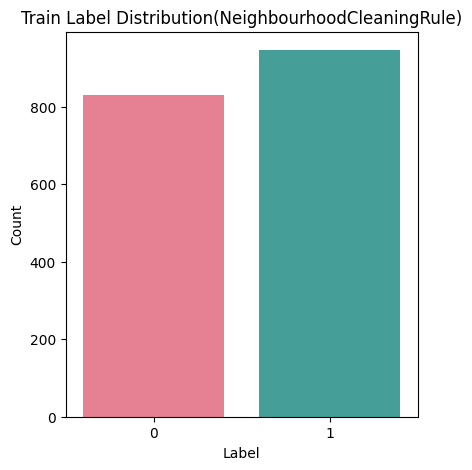

first_party_winner
1    946
0    829
Name: count, dtype: int64


In [15]:
## 패배/승리 데이터 불균형 확인
import seaborn as sns

plt.figure(figsize=(10, 5))


train_label_counts = y_ncr.value_counts()

# 색상 팔레트 생성
palette = sns.color_palette("husl", len(train_label_counts))
plt.subplot(1, 2, 1)
sns.barplot(x=train_label_counts.index, y=train_label_counts.values, palette=palette)
plt.title('Train Label Distribution(NeighbourhoodCleaningRule)')
plt.xlabel('Label')
plt.ylabel('Count')

print(y_ncr.value_counts())


train_label_counts = y_smote.value_counts()
plt.subplot(1, 2, 2)
sns.barplot(x=train_label_counts.index, y=train_label_counts.values, palette=palette)
plt.title('Train Label Distribution(SMOTE)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print(y_smote.value_counts())

# 모델링

## 데이터 분리

train데이터 셋으로 train, val 데이터 셋으로 분리

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_ncr, y_ncr, random_state = 123, test_size = 0.2, 
                                                 stratify = y_ncr)

print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print(y_train.value_counts())

print()

print('Validation shape : {}, {}'.format(X_val.shape, y_val.shape))
print(y_val.value_counts())

Train shape : (1323, 204261), (1323,)
first_party_winner
0    663
1    660
Name: count, dtype: int64

Validation shape : (331, 204261), (331,)
first_party_winner
0    166
1    165
Name: count, dtype: int64


In [15]:
model = LogisticRegression(max_iter = 500, random_state = 123)
model.fit(X_train, y_train)
pred = model.predict(X_val)

print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       166
           1       0.67      0.44      0.53       165

    accuracy                           0.61       331
   macro avg       0.63      0.61      0.60       331
weighted avg       0.63      0.61      0.60       331



=> macro avg는 클래스 별 성능 지표의 단순 평균을 계산

=> weighted avg는 각 클래스의 지지도를 가중치로 사용하여 계산된 평균

=> 모델이 양성 및 음성 클래스를 비교적 균형있게 예측하고 있으며, 적절한 성능을 보이고 있는 것으로 해석

In [16]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.9894179894179894
validation accuracy :  0.6132930513595166


# 그리드서치

In [38]:
# model = LogisticRegression(random_state = 42)

# params = {'C' : [0.1, 1, 10, 100], 'max_iter' : [300, 400, 500]}
# grid = GridSearchCV(model, param_grid = params, cv = 5 )

# grid.fit(X_train, y_train)

# best_params = grid.best_params_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [300, 400, 500]})

In [39]:
# # 최적의 하이퍼파라미터로 로지스틱 회귀 모델 생성
# best_logistic = LogisticRegression(**best_params)

# # 모델을 훈련 데이터에 적합
# best_logistic.fit(X_train, y_train)

# # 테스트 데이터에 모델을 적용하여 예측 수행
# pred = best_logistic.predict(X_val)
# print(classification_report(y_val, pred))

LogisticRegression(C=10, max_iter=300)

              precision    recall  f1-score   support

           0       0.54      0.68      0.60       166
           1       0.64      0.50      0.56       189

    accuracy                           0.58       355
   macro avg       0.59      0.59      0.58       355
weighted avg       0.59      0.58      0.58       355



# 제출

In [17]:
y_pred = model.predict(X_test)
submission_df['first_party_winner'] = y_pred
submission_df.to_csv('neighbourhoodcleaningrule_logit.csv', index = False)

In [ ]:
# y_pred  = best_logistic.predict(X_test)
# submission_df['first_party_winner'] = y_pred
# submission_df.to_csv('neighbourhoodcleaningrule_logit.csv', index = False)